# Import PKG

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.models import model_from_json

from sklearn.model_selection import train_test_split

from scipy import signal
import cv2
import math
import os
from pathlib import Path
import json

Using TensorFlow backend.


# Check Image Directoy 

In [2]:
assert os.path.isdir('data/')
assert os.path.isdir('data/IMG')
assert os.path.isfile('data/driving_log.csv') 
print('Tests passed : Required inputs are there !')

Tests passed : Required inputs are there !


# Import Data

In [3]:
#rows, cols, ch = 64, 64, 3
TARGET_SIZE = (64, 64)
TARGET_SHAPE = (64, 64, 3)
new_size_col = 64
new_size_row = 64

driving_csv = pd.read_csv("data/driving_log.csv", index_col = False)
driving_csv['direction'] = pd.Series('s', index=driving_csv.index)
driving_csv.columns = ['center', 'left', 'right', 'steer', 'throttle', 'brake', 'speed','direction']
driving_csv.head()
print(driving_csv.shape)

(8036, 8)


# Data Stats

In [4]:
driving_csv.describe(include='all')

,center,left,right,steer,throttle,brake,speed,direction
count,8036,8036,8036,8036.000000,8036.000000,8036.000000,8036.000000,8036
unique,8036,8036,8036,NaN,NaN,NaN,NaN,1
top,IMG/center_2016_12_01_13_33_16_856.jpg,IMG/left_2016_12_01_13_45_19_077.jpg,IMG/right_2016_12_01_13_42_54_129.jpg,NaN,NaN,NaN,NaN,s
freq,1,1,1,NaN,NaN,NaN,NaN,8036
mean,NaN,NaN,NaN,0.004070,0.869660,0.001970,28.169839,NaN
std,NaN,NaN,NaN,0.128840,0.301326,0.036565,6.149327,NaN
min,NaN,NaN,NaN,-0.942695,0.000000,0.000000,0.502490,NaN
25%,NaN,NaN,NaN,0.000000,0.985533,0.000000,30.183093,NaN
50%,NaN,NaN,NaN,0.000000,0.985533,0.000000,30.186400,NaN
75%,NaN,NaN,NaN,0.000000,0.985533,0.000000,30.186640,NaN


# Histograph

[[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CDE7A58>]]


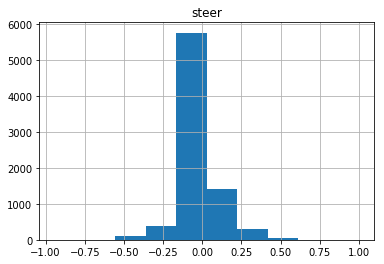

In [5]:
print(driving_csv.hist(column='steer'))

High data with in small steering angle means that there will be high bias toward going straight (see histogram). This will cause overfitting. We could use high volume of data sample (which is not practical), In order to make the most of our “relatively” few training examples, we will "augment” data via a number of random transformations, so that our model would never see twice the exact same picture.  

Note augmentations are very specific to the objective/application of the neural network. There is no such thing as generic augmentation functions.

Just Augmentation is not enough for fighting overfitting !!!!   Main focus for fighting overfitting should be the entropic capacity of model.  Model should not store irrelevant data, only important features. To do that we have to play around with parameters of networks like number of layers, size of each layer, size of filter and dropout function and etc.  

Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation.  see function "Generate_Training_Data_batch" for intial "random" filtering of high Probability low steering angle data. 

Both dropout and data augmentation tend to disrupt random correlations occurring in data.


In project we have done normailization, croping image & dropout/filtering as part of pre-processing. 
(note that The first layer of the network also performs image normalization. This normalizer is hard-coded and is not
adjusted in the learning process). 

Image cropping (and resizing) is done to remove unwanted images. like sky in top and car hood in lower image. 


To generate training sequence I have written few image augmentation function  
1. Augment_Brightness
2. Augment_Steering_Angle
3. Augment_Flip_Direction
4. Augment_Translation (on axis only ie horzontal and vertical) 
5. Augment_Shadow
6. Augment_image_through_Rotation  (not working as of right now/not used)

Working of each "Augment function" is writen in comments in functions. 
there sections below showing testing of each functions. 

Structure of Network 
I got this structure form "End to End Learning for Self-Driving Cars" paper from NVIDIA. 

The network consists of 9 layers, including a normalization layer, 5 convolutional layers
and 3 fully connected layers.

The normalizer is hard-coded and is not adjusted in the learning process. 

Description of Network (copied from paper)
The convolutional layers were designed to perform feature extraction and were chosen empirically
through a series of experiments that varied layer configurations. 

We use strided convolutions in the first three convolutional layers with a 2x2 stride and a 5x5 kernel 
and a non-strided convolution with a 3X3 kernel size in the last two convolutional layers.

Five convolutional layers with three fully connected layers leading to an output control 
value which is the inverse turning radius. 

The fully connected layers are designed to function as a controller for steering, but we note that by 
training the system end-to-end, it is not possible to make a clean break between which parts of the 
network function primarily as feature extractor and which serve as controller.

http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

this did help me lot 
https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.ykox6yduo


See last section of this notebook for Changes in drive.py 

# Supporting functions

In [6]:
def Remove_Data_Below_Threshold(csv,key,Threshold):
    #print('Before:',len(csv))
    ind = csv[key]>Threshold
    csv= csv[ind].reset_index()
    #print('After:',len(csv))
    return csv

def Normalize_Image(image_path):
    image = cv2.imread(image_path) 
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image/255.-.5
    return image

def Resize_to_target_size(image):
    #param image: The input image of dimensions 160x320x3
    #return: Output image of size 64x64x3
    return cv2.resize(image, (new_size_col,new_size_row), interpolation=cv2.INTER_AREA)

def Crop_and_Resize(image):
    #removed the top 1/4 of the image to get rid of sky 
    #removed bottom 25 pixels to delete the hood of car from image.
    shape = image.shape
    cropped_image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    processed_image = Resize_to_target_size(cropped_image)        
    return processed_image

def Save_Model_And_Weights(model, model_file_name ,weights_file_name):
    if Path(model_file_name).is_file():
        os.remove(model_file_name)
        
    json_string = model.to_json()
    with open(model_file_name,'w' ) as f:
        json.dump(json_string, f)

    if Path(weights_file_name).is_file():
        os.remove(weights_file_name)
    model.save_weights(weights_file_name)

# Augment Functions (For training data)

To develop powerful classifiers additional data will be created manipulating the incoming training data 
These augments are very specific to the objective of the neural network. 

In [7]:
def Augment_Brightness(image):
    #return: output image with adjusted brightness
        
    constant = 0.25
    #converted RGB image to HSV, scaled V (brightness) channel by a random number between .25 and 1.25, 
    #output is converted back to RGB
    #reason for adding constant is to avoid complete darkness. 
    
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = constant+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def Augment_Steering_Angle(row):
    #Using left and right camera images to simulate the effect of car wandering off to the side, and recovering.
    #We will add a small angle .25 to the left camera and subtract a small angle of 0.25 from the right camera. 
    #The main idea being the left camera has to move right to get to center, and right camera has to move left.
            
    steering = row['steer'][0]
    # randomly choose the camera to take the image from
    camera = np.random.choice(['center', 'left', 'right'])
    # adjust the steering angle for left anf right cameras
    if camera == 'left':
        steering += 0.25
    elif camera == 'right':
        steering -= 0.25
    #elif camera == 'center':
    #    steering += 0

    image_path = 'data/'+row[camera][0].strip()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    return image,steering,camera


def Augment_Flip_Direction(row):    
    #flip images at random and change the sign of the predicted angle 
    #to simulate driving in the opposite direction.
    
    steering = row['steer'][0]
    camera = np.random.choice(['center', 'left', 'right'])
    image_path = 'data/'+row[camera][0].strip()
    #image = load_img("data/" + row[camera])
    #image = img_to_array(image)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #image = cv2.flip(image, 1)
    #steering = -1*steering
    
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        # flip the image and reverse the steering angle
        steering = -1*steering
        image = cv2.flip(image, 1)
    
    return image,steering


def Augment_Translation(image,steer,trans_range):
    # Translation
    
    # Horizontal shifts
    # to simulate the effect of car being at different positions on the road,
    # add an offset corresponding to the shift to the steering angle. 
    
    # We added 0.004 steering angle units per pixel shift to the right, 
    # and subtracted 0.004 steering angle units per pixel shift to the left.
        
    # Vertical shifts
    # shift the images vertically by a random number to simulate the effect of driving up or down the slope.
    rows,cols,channels = image.shape
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2 # for Horizontal shifts      
    tr_y = 10*np.random.uniform()-10/2 # for Vertical shifts
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))  
  
    return image_tr,steer_ang,tr_x



def Augment_Shadow(image):
    #This is implemented by choosing random points and shading all points 
    #on one side (chosen randomly) of the image.
    
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]

    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

# Augment Steering Angle (Test)

data/IMG/center_2016_12_01_13_32_46_890.jpg


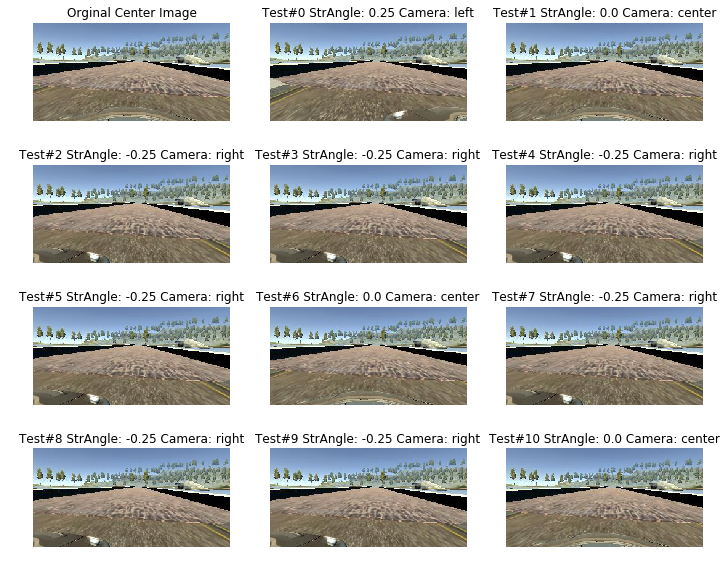

In [8]:
ind_num = 85
row = driving_csv.loc[ind_num:ind_num].reset_index()
steer = row['steer'][0]
center_image_path = 'data/'+row['center'][0].strip()
print(center_image_path)
image = cv2.imread(center_image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,10))
plt.subplot(4,3,1)
plt.imshow(image)
plt.title('Orginal Center Image')
plt.axis('off')

for i in range(11):
    plt.subplot(4,3,i+2)
    ag_image,ag_steering,ag_camera = Augment_Steering_Angle(row)
    #ag_image = Crop_and_Resize(ag_image)
    plt.title('Test#' + str(i)+' StrAngle: ' + str(np.round(ag_steering,2)) +' Camera: ' + ag_camera)
    plt.imshow(ag_image)
    plt.axis('off');

# Augment Flip (Test)

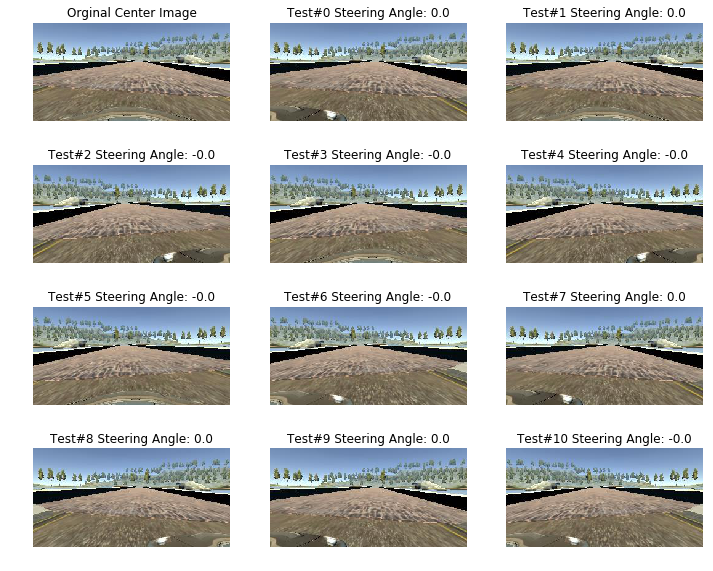

In [9]:
ind_num = 85
row = driving_csv.loc[ind_num:ind_num].reset_index()
steer = row['steer'][0]
center_image_path = 'data/'+row['center'][0].strip()

image = cv2.imread(center_image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,10))
plt.subplot(4,3,1)
plt.imshow(image)
plt.title('Orginal Center Image')
plt.axis('off')

for i in range(11):
    plt.subplot(4,3,i+2)
    ag_image,ag_steering = Augment_Flip_Direction(row)
    #ag_image = Crop_and_Resize(ag_image)
    plt.title('Test#' + str(i)+' Steering Angle: ' + str(np.round(ag_steering,2)) )
    plt.imshow(ag_image)
    plt.axis('off');

# Augment Brightness(Test)

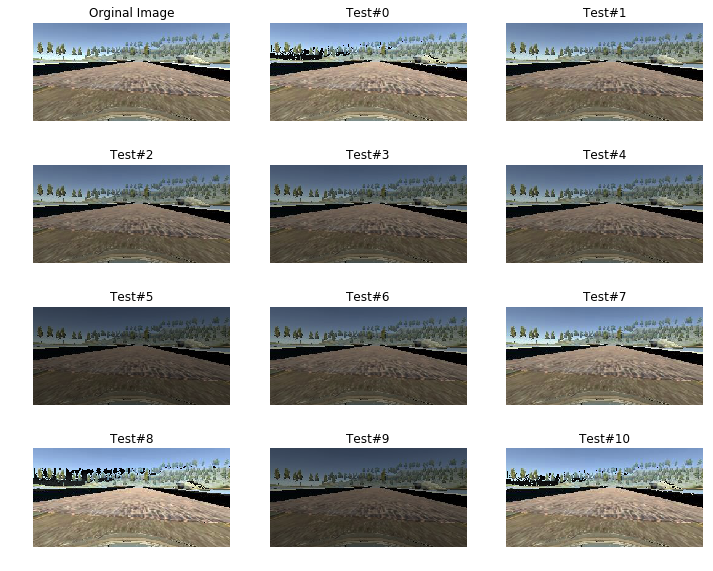

In [10]:
ind_num = 85
row = driving_csv.loc[ind_num:ind_num]
steer = row['steer'][ind_num]
speed = row['speed'][ind_num]
center_image_path = 'data/'+row['center'][ind_num].strip()

image = cv2.imread(center_image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,10))
plt.subplot(4,3,1)
plt.imshow(image)
plt.title('Orginal Image')
plt.axis('off')

for i in range(11):
    plt.subplot(4,3,i+2)
    ag_image = Augment_Brightness(image)
    #ag_image = Crop_and_Resize(ag_image)
    plt.title('Test#' + str(i) )
    plt.imshow(ag_image)
    plt.axis('off');

# Augment Shadow (Test)

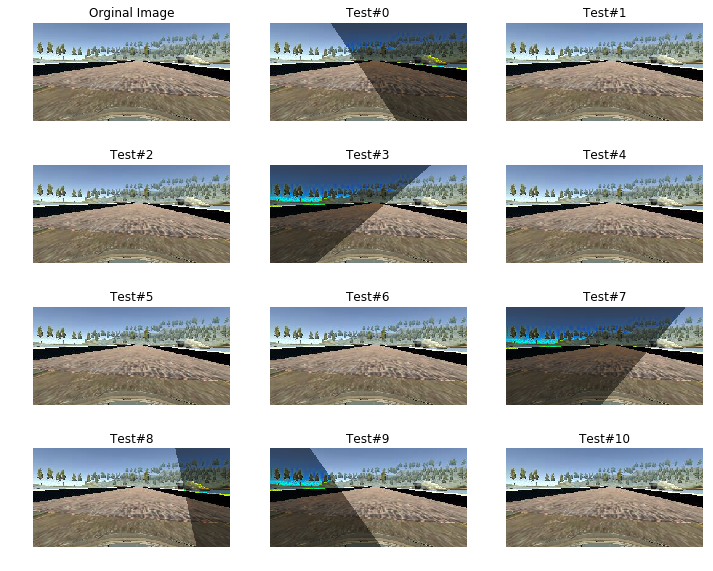

In [11]:
ind_num = 85
row = driving_csv.loc[ind_num:ind_num]
steer = row['steer'][ind_num]
speed = row['speed'][ind_num]
center_image_path = 'data/'+row['center'][ind_num].strip()

image = cv2.imread(center_image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,10))
plt.subplot(4,3,1)
plt.imshow(image)
plt.title('Orginal Image')
plt.axis('off')

for i in range(11):
    plt.subplot(4,3,i+2)
    ag_image = Augment_Shadow(image)
    #ag_image = Crop_and_Resize(ag_image)
    plt.title('Test#' + str(i) )
    plt.imshow(ag_image)
    plt.axis('off');

# Augment Translation (Test)

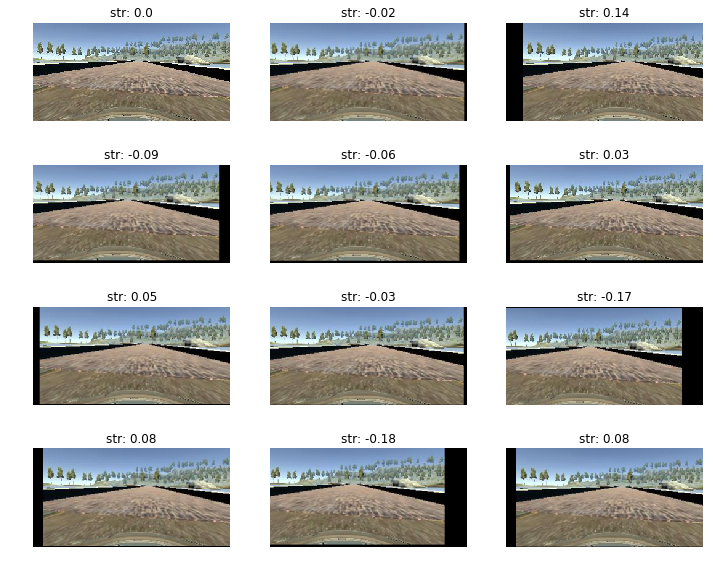

In [12]:
ind_num = 85
row = driving_csv.loc[ind_num:ind_num]
steer = row['steer'][ind_num]
speed = row['speed'][ind_num]
center_image_path = 'data/'+row['center'][ind_num].strip()

image = cv2.imread(center_image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,10))
plt.subplot(4,3,1)
plt.imshow(image)
plt.title('str: ' + str(np.round(steer,2)))
plt.axis('off')

for i in range(11):
    plt.subplot(4,3,i+2)
    image_tr,steer_ang,tr_x = Augment_Translation(image,steer,80)
    plt.title('str: ' + str(np.round(steer_ang,2)) )
    plt.imshow(image_tr)
    plt.axis('off');

# Create Left & Right image out Center Image (Not working properly)

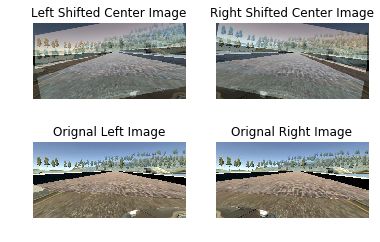

In [13]:
angle_rot = 10
trans_camera = 5

ind_num = 85
row = driving_csv.loc[ind_num:ind_num]

right_image_path = 'data/'+row['right'][ind_num].strip()
left_image_path = 'data/'+row['left'][ind_num].strip()
center_image_path = 'data/'+row['center'][ind_num].strip()

image_c = cv2.imread(center_image_path)
image_c = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_r = cv2.imread(right_image_path)
image_r = cv2.cvtColor(image_r,cv2.COLOR_BGR2RGB)
image_l = cv2.imread(left_image_path)
image_l = cv2.cvtColor(image_l,cv2.COLOR_BGR2RGB)

rows,cols,channels = image_c.shape

Mt = np.float32([[1,0,-trans_camera],[0,1,0]])
Mr = cv2.getRotationMatrix2D((cols/2,rows/2),-angle_rot,1)    # Rotation Matrix // negative shift for right
image_c_mod = cv2.warpAffine(image_c,Mr,(cols,rows))
image_c_mod = cv2.warpAffine(image_c_mod,Mt,(cols,rows))
image_rc_mod = cv2.addWeighted(image_r,0.5,image_c_mod,0.5,0) # Blend two images


Mt = np.float32([[1,0,trans_camera],[0,1,0]])
Mr = cv2.getRotationMatrix2D((cols/2,rows/2),angle_rot,1)     # Rotation Matrix // Positive shift for Left
image_c_mod = cv2.warpAffine(image_c,Mr,(cols,rows))
image_c_mod = cv2.warpAffine(image_c_mod,Mt,(cols,rows))
image_lc_mod = cv2.addWeighted(image_l,0.5,image_c_mod,0.5,0) # Blend two images 


plt.subplot(2,2,1)
plt.title('Left Shifted Center Image')
plt.imshow(image_lc_mod)
plt.axis('off')
plt.subplot(2,2,2)
plt.title('Right Shifted Center Image')
plt.imshow(image_rc_mod)
plt.axis('off');
plt.subplot(2,2,3)
plt.title('Orignal Left Image')
plt.imshow(image_l)
plt.axis('off');
plt.subplot(2,2,4)
plt.title('Orignal Right Image')
plt.imshow(image_r)
plt.axis('off');

# Model (NVIDIA End to End Learning Pipeline Model)

Reference: [NVIDIA's 'End to End Learning for Self-Driving Cars' (April 2016)](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf)

In [14]:
# NVIDIA End to End Learning Pipeline Model

model = Sequential()

# Normalise data
model.add(Lambda(lambda x: x/255.-0.5, input_shape=TARGET_SHAPE))

# Conv layer 1, 5x5 kernel to 24@ (from 3@)
# Stride of 2x2
model.add(Convolution2D(24, 5, 5, input_shape=(160,320,3)))
#model.add(Activation('elu'))
model.add(ELU())
model.add(Dropout(0.1))

# Conv layer 2, 5x5 kernel to 36@
model.add(Convolution2D(36, 5, 5))
#model.add(Activation('elu'))
model.add(ELU())
model.add(Dropout(0.1))

# Conv layer 3, 5x5 kernel to 48@
model.add(Convolution2D(48, 5, 5))
#model.add(Activation('elu'))
model.add(ELU())
model.add(Dropout(0.1))

# Conv layer 4, 3x3 kernel to 64@
model.add(Convolution2D(64, 3, 3))
#model.add(Activation('elu'))
model.add(ELU())
model.add(Dropout(0.1))

# Conv layer 5, 3x3 kernel to 64@
model.add(Convolution2D(64, 3, 3))
#model.add(Activation('elu'))
model.add(ELU())
model.add(Dropout(0.1))

# Flatten
model.add(Flatten())

# Fully connected layer 1, 1164 neurons
model.add(Dense(1164))
#model.add(Activation('elu'))
model.add(ELU())
model.add(Dropout(0.1))

# Fc2, 100 neurons
model.add(Dense(100))
#model.add(Activation('elu'))
model.add(ELU())
model.add(Dropout(0.1))

# Fc3, 50 neurons
model.add(Dense(50))
#model.add(Activation('elu'))
model.add(ELU())
model.add(Dropout(0.1))

# Fc4, 10 neurons
model.add(Dense(10))
#model.add(Activation('elu'))
model.add(ELU())
model.add(Dropout(0.1))

# Output
model.add(Dense(1))

# Compile model
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 60, 60, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 60, 60, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 60, 60, 24)    0           elu_1[0][0]                      
___________________________________________________________________________________________

# Generate Validation Data

In [15]:
def Generate_Validation_Data(data):
    while 1:
        for i in range(len(data)):
            line_data = data.iloc[[i]]
            
            path_file = 'data/'+line_data['center'][i].strip()
            image = cv2.imread(path_file)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = Crop_and_Resize(image)
            x = np.array(image)  
            
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = line_data['steer'][i]
            y = np.array([[y]])
            yield x, y

# Generate Training Data

In [16]:
def Get_Augmented_Data(row):
    
    image,steer,camera = Augment_Steering_Angle(row)
    ag_image,ag_steering = Augment_Flip_Direction(row)
    image = Augment_Brightness(image)
    image = Augment_Shadow(image)
    image,steer,tr_x = Augment_Translation(image,steer,80)
        
   
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        steer = -steer  
     
    image = Crop_and_Resize(image)
    
    return image,steer





pr_threshold = 1

def Generate_Training_Data_batch(data,batch_size = 32):    
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            
            keep_pr = 0
            while keep_pr == 0:
                x,y = Get_Augmented_Data(line_data)
                pr_unif = np.random
                if abs(y)<.15:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering

# Final Processing Loop

In [17]:
valid_s_generator = Generate_Validation_Data(driving_csv)
val_size = len(driving_csv)
pr_threshold = 1

batch_size = 256

i_best = 0
val_best = 1000 

for i_pr in range(10):

    train_r_generator = Generate_Training_Data_batch(driving_csv,batch_size)

    nb_vals = np.round(len(driving_csv)/val_size)-1
    
    history = model.fit_generator(train_r_generator, 
                                  samples_per_epoch=20224, 
                                  nb_epoch=1,
                                  validation_data=valid_s_generator, 
                                  nb_val_samples=val_size)
    
    model_file = 'model_' + str(i_pr) + '.json'
    weight_file = 'model_' + str(i_pr) + '.h5'
    
    Save_Model_And_Weights(model,model_file,weight_file)
    
    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        i_best = i_pr 
        val_best = val_loss
        model_file = 'model_best.json'
        weight_file = 'model_best.h5'
        Save_Model_And_Weights(model,model_file,weight_file)
        
    pr_threshold = 1/(i_pr+1)
print('Best model found at iteration # ' + str(i_best))
print('Best Validation score : ' + str(np.round(val_best,4)))

Epoch 1/1
20224/20224 [==============================] - 6665s - loss: 1.0199 - acc: 0.0000e+00 - val_loss: 0.0308 - val_acc: 0.5421
Epoch 1/1
20224/20224 [==============================] - 6521s - loss: 0.1035 - acc: 0.0000e+00 - val_loss: 0.0288 - val_acc: 0.5427
Epoch 1/1
20224/20224 [==============================] - 6499s - loss: 0.0950 - acc: 0.0000e+00 - val_loss: 0.0431 - val_acc: 0.5389
Epoch 1/1
20224/20224 [==============================] - 6592s - loss: 0.0990 - acc: 0.0000e+00 - val_loss: 0.0311 - val_acc: 0.5385
Epoch 1/1
20224/20224 [==============================] - 6669s - loss: 0.0841 - acc: 0.0000e+00 - val_loss: 0.0276 - val_acc: 0.5413
Epoch 1/1
20224/20224 [==============================] - 6553s - loss: 0.0789 - acc: 0.0000e+00 - val_loss: 0.0271 - val_acc: 0.5387
Epoch 1/1
20224/20224 [==============================] - 6633s - loss: 0.0771 - acc: 0.0000e+00 - val_loss: 0.0260 - val_acc: 0.5422
Epoch 1/1
20224/20224 [==============================] - 6603s - loss

Note that loss is decreasing in each loop 

# Changes in drive.py

MAX_SPEED = 25
MIN_SPEED = 10
speed_limit = MAX_SPEED   #Default Speed 



#lower the throttle as the speed increases if the speed is above the current speed limit, we are on a downhill.
#It make sures we slow down first and then go back to the original max speed.

global speed_limit

if speed > speed_limit:
    speed_limit = MIN_SPEED     
else:
    speed_limit = MAX_SPEED
    
throttle = 1.0 - steering_angle**2 - (speed/speed_limit)**2